In [105]:
# The original version of this notebook was downloaded from: 
# https://www.kaggle.com/code/osamaeldemerdash/image-classification-cnn and
# https://www.kaggle.com/code/pranjalsoni17/natural-scene-classification

#project name
project_name = 'tuttle-twins-image-classification'

In [106]:
!python3 -m pip install --upgrade pip

%pip install pandas
%pip install numpy
%pip uninstall tensorflow
%pip install tensorflow-gpu
%pip install keras
%pip install matplotlib
%pip install opencv-python
print("done")

Looking in indexes: https://pypi.org/simple/
Looking in indexes: https://pypi.org/simple/
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.org/simple/
Note: you may need to restart the kernel to use updated packages.
Found existing installation: tensorflow 2.9.1
Uninstalling tensorflow-2.9.1:
  Would remove:
    /Users/sbecker11/workspace-python/ipywidgets-sandbox/venv/bin/estimator_ckpt_converter
    /Users/sbecker11/workspace-python/ipywidgets-sandbox/venv/bin/import_pb_to_tensorboard
    /Users/sbecker11/workspace-python/ipywidgets-sandbox/venv/bin/saved_model_cli
    /Users/sbecker11/workspace-python/ipywidgets-sandbox/venv/bin/tensorboard
    /Users/sbecker11/workspace-python/ipywidgets-sandbox/venv/bin/tf_upgrade_v2
    /Users/sbecker11/workspace-python/ipywidgets-sandbox/venv/bin/tflite_convert
    /Users/sbecker11/workspace-python/ipywidgets-sandbox/venv/bin/toco
    /Users/sbecker11/workspace-python/ipywidgets-sandbox/venv/bin/

In [84]:
#import libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
sns.set(style="whitegrid")
import datetime
import tensorflow as tf
import keras

%matplotlib inline
print("done")

done


> # **Exploring the Dataset**

In [85]:
# e.g. TT_S01_E02_FRM-00-19-05-09.jpg
SOURCE_IMAGES_DIR = "../src-images/"

# pred_data.csv   test_data.csv   train_data.csv
CSV_DATA_DIR = "../csv-data/"

STAGES = ["train", "test", "pred"]

## Pre-process csv data files

In [94]:
def pre_process_csv_stage_data(stage):
    '''
    read the csv_data file for the given stage
    and return its X_images and y_labels
    '''
    
    assert stage in STAGES
    
    csv_data_file = f"{CSV_DATA_DIR}{stage}_data.csv"
    print(f"pre-processing: {csv_data_file}")
    
    df = pd.read_csv(csv_data_file, header=None, names=['file_name', 'label'])
    X_file_names = df["file_name"].to_list()
    y_labels = df["label"].to_list()
    
    print(f"X_{stage}_file_names: {len(X_file_names)}")
    print(f"y_{stage}labels: {len(y_labels)}")

    # review X image sizes
    X_size = []
    for i in range(len(X_file_names)):
        image = plt.imread(SOURCE_IMAGES_DIR + X_file_names[i])
        X_size.append(image.shape)
    pd.Series(X_size).value_counts()
    
    # Read and resize X_images
    s = 100
    X_images = []
    for i in range(len(X_file_names)):
        im_cv = cv2.imread(SOURCE_IMAGES_DIR + X_file_names[i])
        im_rgb = cv2.cvtColor(im_cv, cv2.COLOR_BGR2RGB)
        image_array = cv2.resize(im_rgb, (s,s), interpolation=cv2.INTER_AREA)
        X_images.append(list(image_array))

    print(f"X_{stage}_images: {len(X_images)} images resized to {s}x{s} pixels")
    
    return (X_images, y_labels)


def create_random_seed(num_digits=3):
    '''
    Use the last num_digits [1..6]chars of the current utc time in 
    ISO8601 format to create a random num_digit number
    '''
    num_digits = min(max(1,num_digits),6)
    iso_str = datetime.datetime.utcnow().isoformat()
    return int(iso_str[-num_digits:])


def display_X_stage_images(stage, X_images, y_labels):
    '''
    Display a random selection of 36 X_images and their y_labels
    '''
    np.random.seed(create_random_seed())
    num_images = min(36, len(X_images))
    print(f"Displaying a random selection of {num_images} X_{stage}_images and their y_{stage}_labels")
    
    plt.figure(figsize=(20,20))
    for n , i in enumerate(list(np.random.randint(0,len(X_images),num_images))) : 
        plt.subplot(6,6,n+1)
        plt.imshow(X_images[i])   
        plt.axis('off')
        plt.title(f"{y_labels[i]} @ {i}")


## Pre-process and display the train data

pre-processing: ../csv-data/train_data.csv
X_train_file_names: 198
y_trainlabels: 198
X_train_images: 198 images resized to 100x100 pixels
Displaying a random selection of 36 X_train_images and their y_train_labels


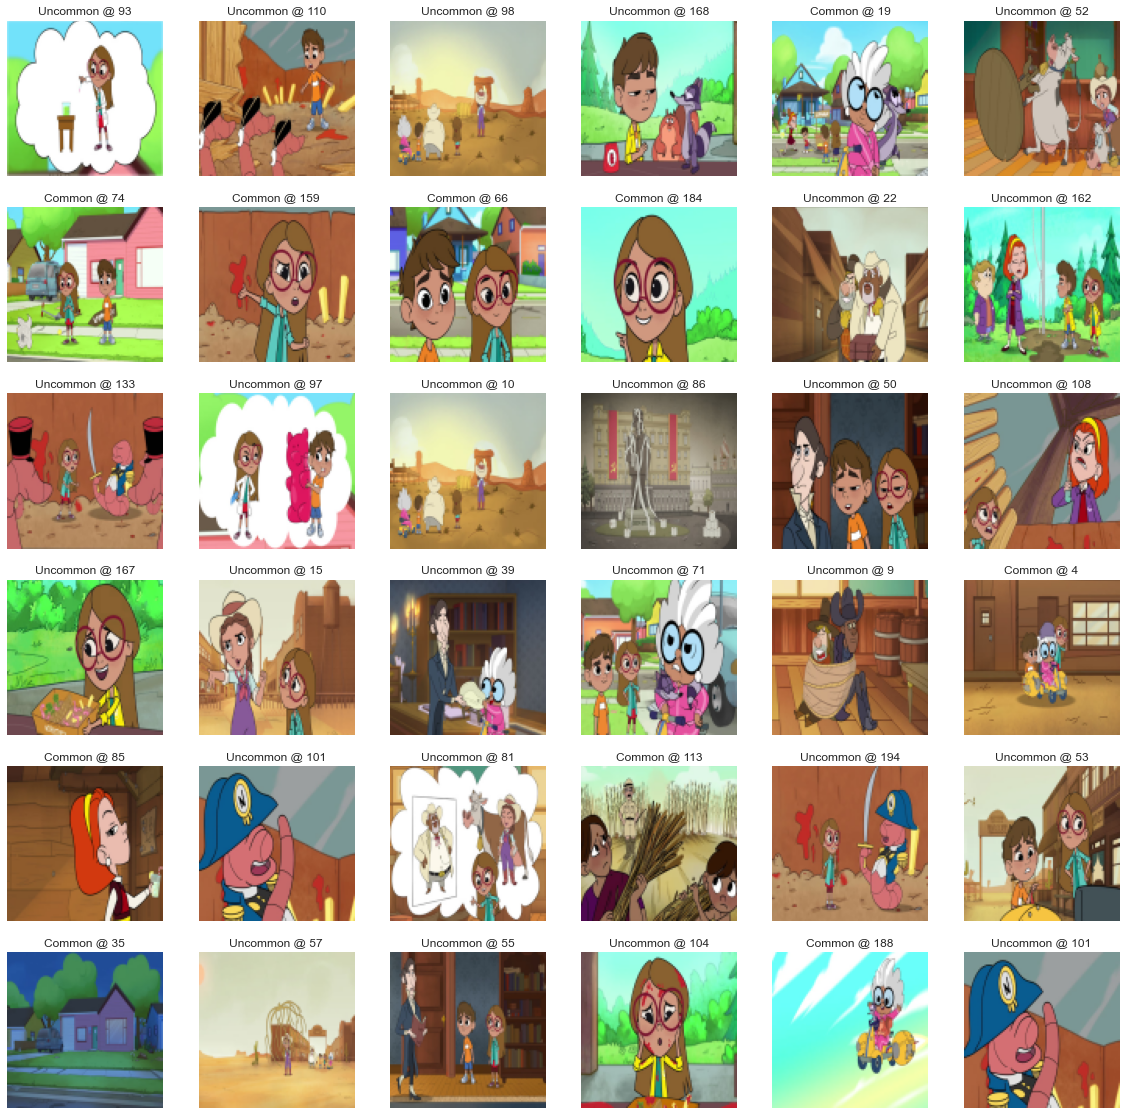

In [95]:
(X_train, y_train) = pre_process_csv_stage_data(stage="train")
display_X_stage_images(stage="train", X_images=X_train, y_labels=y_train)


## Pre-process and display the test data

pre-processing: ../csv-data/test_data.csv
X_test_file_names: 48
y_testlabels: 48
X_test_images: 48 images resized to 100x100 pixels
Displaying a random selection of 36 X_test_images and their y_test_labels


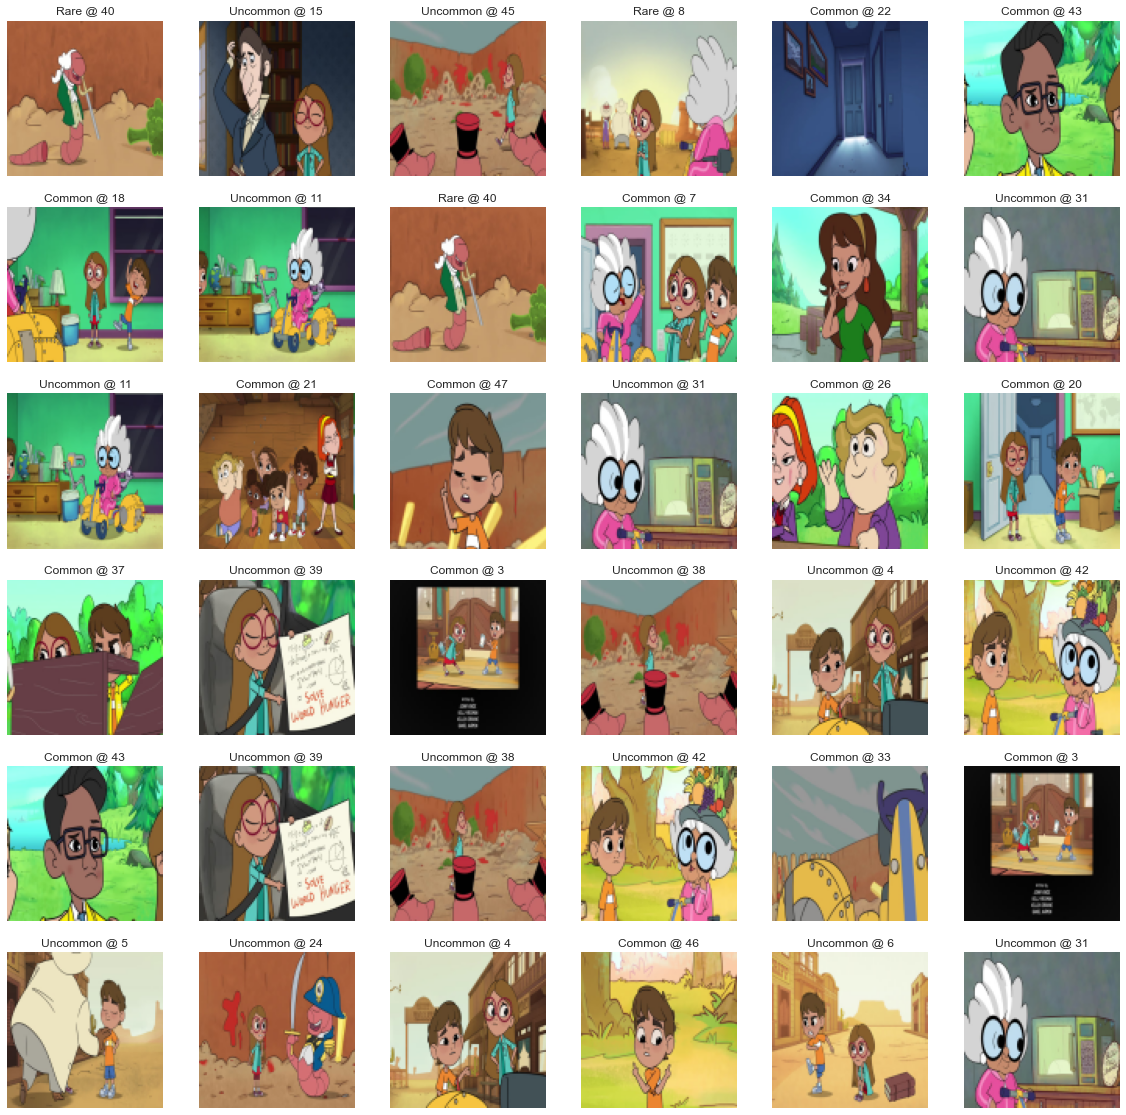

In [96]:
(X_test, y_test) = pre_process_csv_stage_data(stage="test")
display_X_stage_images(stage="test", X_images=X_test, y_labels=y_test)

## Pre-process and display the pred data


pre-processing: ../csv-data/pred_data.csv
X_pred_file_names: 30
y_predlabels: 30
X_pred_images: 30 images resized to 100x100 pixels
Displaying a random selection of 30 X_pred_images and their y_pred_labels


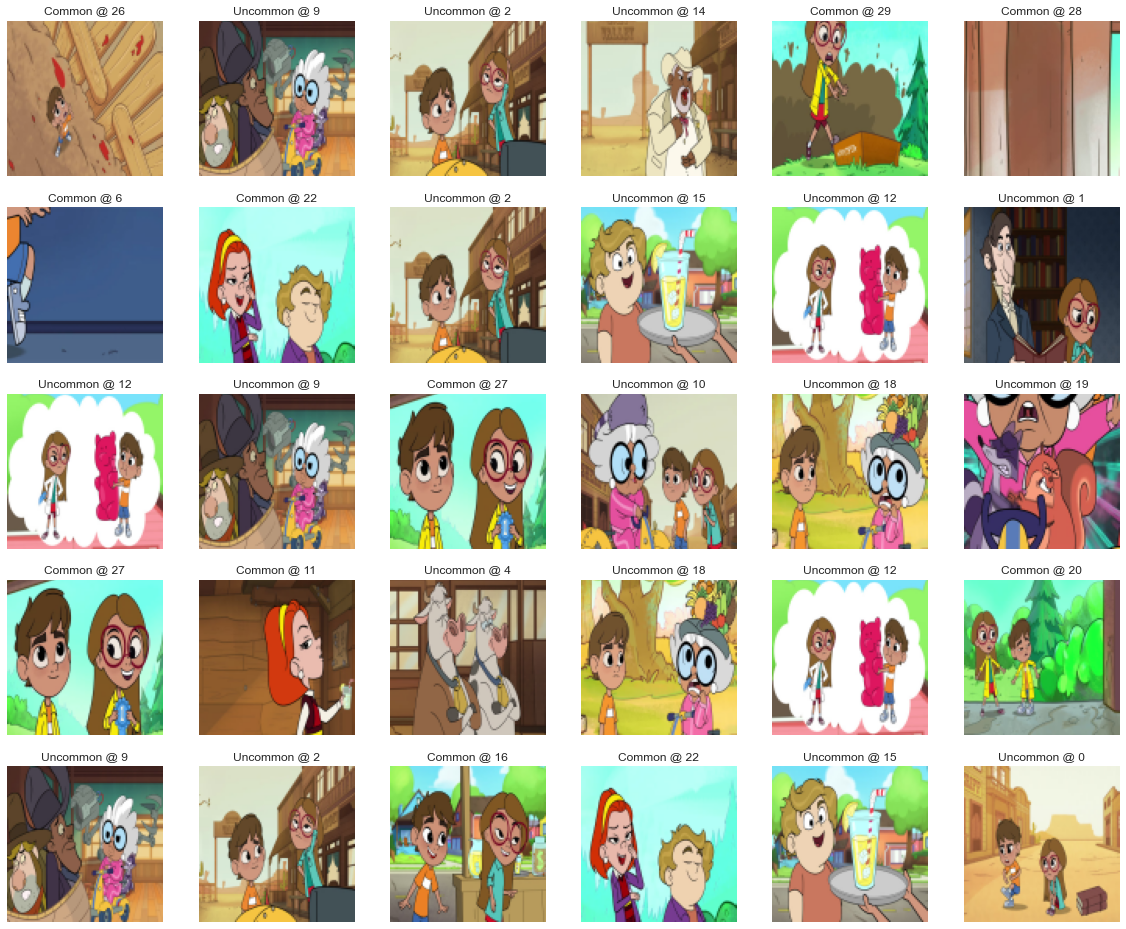

In [97]:
(X_pred, y_pred) = pre_process_csv_stage_data(stage="pred")
display_X_stage_images(stage="pred", X_images=X_pred, y_labels=y_pred)

> # Training and Validation Datasets : 

### Building The Model

In [98]:
X_train = np.array(X_train)
X_test = np.array(X_test)
X_pred = np.array(X_pred)
y_train = np.array(y_train)
y_test = np.array(y_test)

print(f'X_train shape  is {X_train.shape}')
print(f'X_test shape  is {X_test.shape}')
print(f'X_pred shape  is {X_pred.shape}')
print(f'y_train shape  is {y_train.shape}')
print(f'y_test shape  is {y_test.shape}')


X_train shape  is (198, 100, 100, 3)
X_test shape  is (48, 100, 100, 3)
X_pred shape  is (30, 100, 100, 3)
y_train shape  is (198,)
y_test shape  is (48,)


In [101]:
# now to build the CNN model by Keras , using Conv2D layers , MaxPooling & Denses
s = 100
kerasModel = keras.models.Sequential([
        keras.layers.Conv2D(200,kernel_size=(3,3),activation='relu',input_shape=(s,s,3)),
        keras.layers.Conv2D(150,kernel_size=(3,3),activation='relu'),
        keras.layers.MaxPool2D(4,4),
        keras.layers.Conv2D(120,kernel_size=(3,3),activation='relu'),    
        keras.layers.Conv2D(80,kernel_size=(3,3),activation='relu'),    
        keras.layers.Conv2D(50,kernel_size=(3,3),activation='relu'),
        keras.layers.MaxPool2D(4,4),
        keras.layers.Flatten() ,    
        keras.layers.Dense(120,activation='relu') ,    
        keras.layers.Dense(100,activation='relu') ,    
        keras.layers.Dense(50,activation='relu') ,        
        keras.layers.Dropout(rate=0.5) ,            
        keras.layers.Dense(6,activation='softmax') ,    
        ])



In [102]:
# now to compile the model , using adam optimizer , & sparse categorical crossentropy loss

kerasModel.compile(optimizer ='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])



In [103]:
# so what does the model looks like ?

print('Model Details are : ')
print(kerasModel.summary())


Model Details are : 
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 98, 98, 200)       5600      
                                                                 
 conv2d_6 (Conv2D)           (None, 96, 96, 150)       270150    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 24, 24, 150)      0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 22, 22, 120)       162120    
                                                                 
 conv2d_8 (Conv2D)           (None, 20, 20, 80)        86480     
                                                                 
 conv2d_9 (Conv2D)           (None, 18, 18, 50)        36050     
                                 

In [ ]:
# use GPU if it's available

physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [104]:
# now to train the model , lets use 50 epochs now

epochs = 50
thisModel = kerasModel.fit(X_train, y_train, epochs=epochs,batch_size=64,verbose=1)


Epoch 1/50


2022-05-24 00:43:15.546780: W tensorflow/core/framework/op_kernel.cc:1722] OP_REQUIRES failed at cast_op.cc:121 : UNIMPLEMENTED: Cast string to int64 is not supported


UnimplementedError: Graph execution error:

Detected at node 'sparse_categorical_crossentropy/Cast' defined at (most recent call last):
    File "/usr/local/Cellar/python@3.9/3.9.12_1/Frameworks/Python.framework/Versions/3.9/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/local/Cellar/python@3.9/3.9.12_1/Frameworks/Python.framework/Versions/3.9/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/Users/sbecker11/workspace-python/ipywidgets-sandbox/venv/lib/python3.9/site-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/Users/sbecker11/workspace-python/ipywidgets-sandbox/venv/lib/python3.9/site-packages/traitlets/config/application.py", line 846, in launch_instance
      app.start()
    File "/Users/sbecker11/workspace-python/ipywidgets-sandbox/venv/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 677, in start
      self.io_loop.start()
    File "/Users/sbecker11/workspace-python/ipywidgets-sandbox/venv/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/usr/local/Cellar/python@3.9/3.9.12_1/Frameworks/Python.framework/Versions/3.9/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
      self._run_once()
    File "/usr/local/Cellar/python@3.9/3.9.12_1/Frameworks/Python.framework/Versions/3.9/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
      handle._run()
    File "/usr/local/Cellar/python@3.9/3.9.12_1/Frameworks/Python.framework/Versions/3.9/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/Users/sbecker11/workspace-python/ipywidgets-sandbox/venv/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 473, in dispatch_queue
      await self.process_one()
    File "/Users/sbecker11/workspace-python/ipywidgets-sandbox/venv/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 462, in process_one
      await dispatch(*args)
    File "/Users/sbecker11/workspace-python/ipywidgets-sandbox/venv/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 369, in dispatch_shell
      await result
    File "/Users/sbecker11/workspace-python/ipywidgets-sandbox/venv/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 664, in execute_request
      reply_content = await reply_content
    File "/Users/sbecker11/workspace-python/ipywidgets-sandbox/venv/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 355, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/Users/sbecker11/workspace-python/ipywidgets-sandbox/venv/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/Users/sbecker11/workspace-python/ipywidgets-sandbox/venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2854, in run_cell
      result = self._run_cell(
    File "/Users/sbecker11/workspace-python/ipywidgets-sandbox/venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2900, in _run_cell
      return runner(coro)
    File "/Users/sbecker11/workspace-python/ipywidgets-sandbox/venv/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/Users/sbecker11/workspace-python/ipywidgets-sandbox/venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3098, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Users/sbecker11/workspace-python/ipywidgets-sandbox/venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3301, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/Users/sbecker11/workspace-python/ipywidgets-sandbox/venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3361, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/2r/knnqkv9d3w3cwcg76htqtcp00000gp/T/ipykernel_37279/3524392593.py", line 4, in <cell line: 4>
      thisModel = kerasModel.fit(X_train, y_train, epochs=epochs,batch_size=64,verbose=1)
    File "/Users/sbecker11/workspace-python/ipywidgets-sandbox/venv/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/sbecker11/workspace-python/ipywidgets-sandbox/venv/lib/python3.9/site-packages/keras/engine/training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "/Users/sbecker11/workspace-python/ipywidgets-sandbox/venv/lib/python3.9/site-packages/keras/engine/training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "/Users/sbecker11/workspace-python/ipywidgets-sandbox/venv/lib/python3.9/site-packages/keras/engine/training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/sbecker11/workspace-python/ipywidgets-sandbox/venv/lib/python3.9/site-packages/keras/engine/training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "/Users/sbecker11/workspace-python/ipywidgets-sandbox/venv/lib/python3.9/site-packages/keras/engine/training.py", line 890, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/Users/sbecker11/workspace-python/ipywidgets-sandbox/venv/lib/python3.9/site-packages/keras/engine/training.py", line 948, in compute_loss
      return self.compiled_loss(
    File "/Users/sbecker11/workspace-python/ipywidgets-sandbox/venv/lib/python3.9/site-packages/keras/engine/compile_utils.py", line 201, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/Users/sbecker11/workspace-python/ipywidgets-sandbox/venv/lib/python3.9/site-packages/keras/losses.py", line 139, in __call__
      losses = call_fn(y_true, y_pred)
    File "/Users/sbecker11/workspace-python/ipywidgets-sandbox/venv/lib/python3.9/site-packages/keras/losses.py", line 243, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/Users/sbecker11/workspace-python/ipywidgets-sandbox/venv/lib/python3.9/site-packages/keras/losses.py", line 1860, in sparse_categorical_crossentropy
      return backend.sparse_categorical_crossentropy(
    File "/Users/sbecker11/workspace-python/ipywidgets-sandbox/venv/lib/python3.9/site-packages/keras/backend.py", line 5223, in sparse_categorical_crossentropy
      target = cast(target, 'int64')
    File "/Users/sbecker11/workspace-python/ipywidgets-sandbox/venv/lib/python3.9/site-packages/keras/backend.py", line 2066, in cast
      return tf.cast(x, dtype)
Node: 'sparse_categorical_crossentropy/Cast'
Cast string to int64 is not supported
	 [[{{node sparse_categorical_crossentropy/Cast}}]] [Op:__inference_train_function_2565]

In [ ]:
modelLoss, modelAccuracy = kerasModel.evaluate(X_test, y_test)

print('Test Loss is {}'.format(modelLoss))
print('Test Accuracy is {}'.format(modelAccuracy ))


In [ ]:
# now to predict X test

y_pred = kerasModel.predict(X_test)

print(f"y_pred.shape {y_pred.shape} for X_test.shape {X_test.shape}")

In [ ]:
y_result = kerasModel.predict(X_pred)

print(f"y_result.shape {y_result.shape} for X_pred.shape {X_pred.shape}")

# display the predicted y_result labels for X_pred images 

num_images = max(36,len(X_pred))
plt.figure(figsize=(20,20))
for n , i in enumerate(list(np.random.randint(0,len(X_pred),num_images))) : 
    plt.subplot(6,6,n+1)
    plt.imshow(X_pred[i])    
    plt.axis('off')
    plt.title(getcode(np.argmax(y_result[i])))

<!-- Save the parmeters to jovian plateform -->